In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
import pandas as pd

x=pd.read_csv('train.csv')
y=x.pop('Survived')

In [6]:
x.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
x['Age'].fillna(x.Age.mean(),inplace=True)
numeric_variables=list(x.dtypes[x.dtypes!=object].index)

In [10]:
model=RandomForestRegressor(n_estimators=100,oob_score=True,random_state=42)
model.fit(x[numeric_variables],y)
# first model without any feature engineering or data visualization

RandomForestRegressor(oob_score=True, random_state=42)

In [12]:
model.oob_score_

0.1361695005913669

In [15]:
y_oob =model.oob_prediction_
print('c-stat: ',roc_auc_score(y,y_oob))

c-stat:  0.7399551550399983


In [32]:
m=list(x.columns[x.dtypes=='object'])
m

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [34]:
x.drop(['Name','Ticket','PassengerId'],axis=1,inplace=True)

In [36]:
def cabin(x):
    try:
        return x[0]
    except TypeError:
        return None
x['Cabin']=x.Cabin.apply(cabin)

In [38]:
categorical_variables=['Sex','Cabin','Embarked']

                       
                       
            

In [41]:
for _ in categorical_variables:
    x[_].fillna('Missing',inplace=True)
    dummies=pd.get_dummies(x[_],prefix=_)
    x=pd.concat([x,dummies],axis=1)
    x.drop([_],axis=1,inplace=True)
    

KeyError: 'Sex'

In [42]:
x.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [43]:
x['Parch'].max()

6

In [46]:
model=RandomForestRegressor(100,oob_score=True,n_jobs=-1,random_state=42)
model.fit(x,y)
print('C-stat:',roc_auc_score(y,model.oob_prediction_))

C-stat: 0.8641948678618221


<AxesSubplot:>

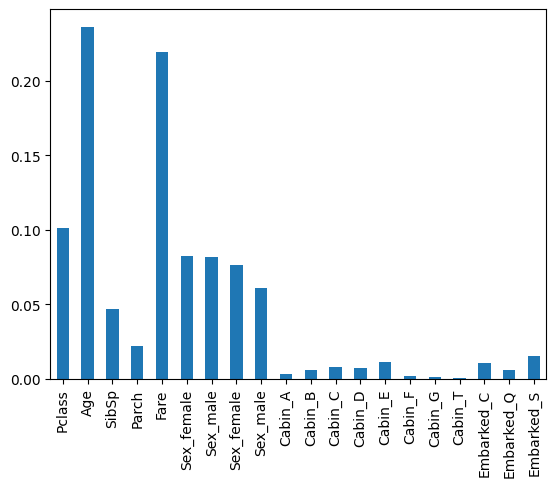

In [58]:
feature_importances=pd.Series(model.feature_importances_,index=x.columns)
feature_importances.sort_index()
feature_importances.plot(kind='bar')

In [60]:
%%timeit
model=RandomForestRegressor(1000,oob_score=True,n_jobs=1,random_state=42)
model.fit(x,y)

2.87 s ± 398 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
%%timeit
model=RandomForestRegressor(1000,oob_score=True,n_jobs=-1,random_state=42)
model.fit(x,y)

2.89 s ± 55.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
results=[]
n_estimator_options=[30,50,100,200,500,1000,2000]
for trees in n_estimator_options:
    model=RandomForestRegressor(trees,oob_score=True,n_jobs=-1, random_state=42)
    model.fit(x,y)
    print(trees, 'trees')
    roc = roc_auc_score(y,model.oob_prediction_)
    print('C-stat:',roc)
    results.append(roc)
    print('')
#     pd.Series(results,n_estimator_options).plot()
    

30 trees
C-stat: 0.8561712417047476

50 trees
C-stat: 0.8629246157287571

100 trees
C-stat: 0.8641948678618221

200 trees
C-stat: 0.862783476602861

500 trees
C-stat: 0.8629459197477606

1000 trees
C-stat: 0.8630923848784073

2000 trees
C-stat: 0.8635397692774741



In [72]:
results=[]
max_features_options=['auto',None,'sqrt','log2',0.9,0.2]

for max_features in max_features_options:
    model=RandomForestRegressor(n_estimators=100,oob_score=True,n_jobs=-1, random_state=42,max_features=max_features)
    model.fit(x,y)
    print(max_features, 'option')
    roc = roc_auc_score(y,model.oob_prediction_)
    print('C-stat:',roc)
    results.append(roc)
    print('')


D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


auto option
C-stat: 0.8641948678618221

None option
C-stat: 0.8641948678618221

sqrt option
C-stat: 0.858488053771344

log2 option
C-stat: 0.858488053771344

0.9 option
C-stat: 0.8637954175055125

0.2 option
C-stat: 0.858488053771344



In [73]:
results=[]
min_samples_leaf_options=[1,2,3,4,5,6,7,8,9,10]

for min_samples in min_samples_leaf_options:
    model=RandomForestRegressor(n_estimators=100,oob_score=True,n_jobs=-1, random_state=42,max_features='auto',min_samples_leaf=min_samples)
    model.fit(x,y)
    print(min_samples, 'samples')
    roc = roc_auc_score(y,model.oob_prediction_)
    print('C-stat:',roc)
    results.append(roc)
    print('')

D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


1 samples
C-stat: 0.8641948678618221



D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


2 samples
C-stat: 0.8712544871590026



D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


3 samples
C-stat: 0.8729481566697558



D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


4 samples
C-stat: 0.874796280318282



D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


5 samples
C-stat: 0.8756511040807848

6 samples
C-stat: 0.8737763504085044



D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


7 samples
C-stat: 0.8719814868074863



D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


8 samples
C-stat: 0.8701520041755877



D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


9 samples
C-stat: 0.8680855143322789



D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


10 samples
C-stat: 0.865363925904622



In [75]:
model=RandomForestRegressor(n_estimators=100,oob_score=True,n_jobs=-1,random_state=42,max_features='auto',min_samples_leaf=5)
model.fit(x,y)
roc=roc_auc_score(y,model.oob_prediction_)
print('Stats: ',roc)

D:\Python\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Stats:  0.8756511040807848
